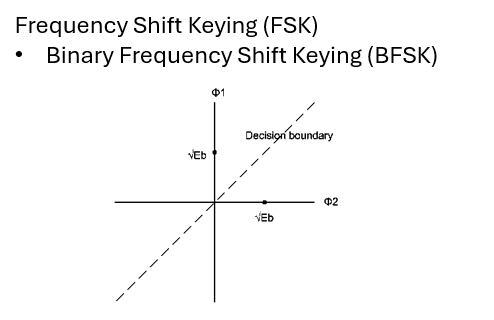

# **BFSK**

# 0. Librerie e parametri iniziali

In [ ]:
"""
Created on: Mon Nov 18 12:47:27 2024
Last modified: Tue Nov 26 13:36 2024
@author: giovanni bolla
"""
# from IPython import get_ipython
# from IPython.display import display
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

plt.close('all')

In [ ]:

### Parametri
Eb_N0_dB = np.arange(0, 21, 2)  # da 0 a 20 con passo di 2 = 11 elementi che esprimono il contrasto di energia in dB
print(Eb_N0_dB)

Eb_N0 = 10 ** (Eb_N0_dB / 10)   # Conversione in scala lineare = 11 elementi
print(Eb_N0)

N0 = 1                          # Valore di N0
Eb = N0 * Eb_N0                 # Energia del bit = 11 elementi
T = 1                           # Periodo
A = np.sqrt(Eb / T)             # Ampiezza del segnale = 11 elementi
K = int(1e5)                    # Numero di campioni = 100mila
soglia = 0.5                    # Soglia di decisione


[ 0  2  4  6  8 10 12 14 16 18 20]
[  1.           1.58489319   2.51188643   3.98107171   6.30957344
  10.          15.84893192  25.11886432  39.81071706  63.09573445
 100.        ]


# 1. Costellazione


[False  True  True ...  True  True False]
(1+0j) 1j
0.0 1.0
[ 0.40904561-0.23016261j  0.03465675+0.82141519j  0.39865609-0.72982578j
 ... -0.51160895-0.70363283j -0.4158088 -0.922556j
 -0.51535429+0.0988768j ]
(100000,)


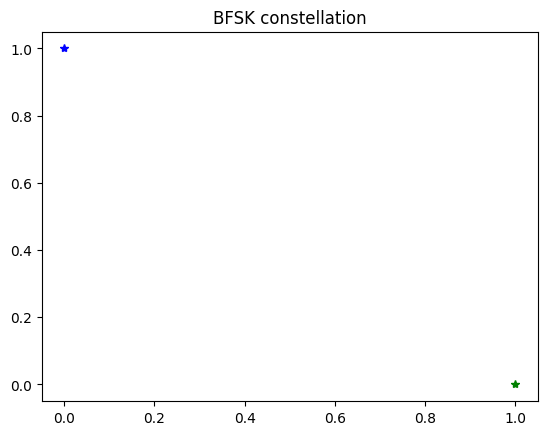

In [ ]:
### Costellazione
b_seq = np.random.rand(int(K)) > soglia  # genera 100mila numeri casuali uniformemente distribuiti tra 0 e 1

#xi_seq = (-1) ** b_seq                   # Mappatura BPSK:  0-->1    1-->-1
xi_seq = np.where(b_seq == 0, 1, 1j)  # If b_seq is 0, xi_seq is 1, else xi_seq is 1j                                   # serve la normalizzazione: np.sqrt(1/2) ??????

noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part

print(b_seq)
print(xi_seq[0],xi_seq[1])
print(xi_seq[1].real,xi_seq[1].imag)
print(noise)
print(noise.shape)

plt.plot(xi_seq[0].real, xi_seq[0].imag, "g*")
plt.plot(xi_seq[1].real, xi_seq[1].imag, "b*")
plt.title("BFSK constellation")
plt.show()

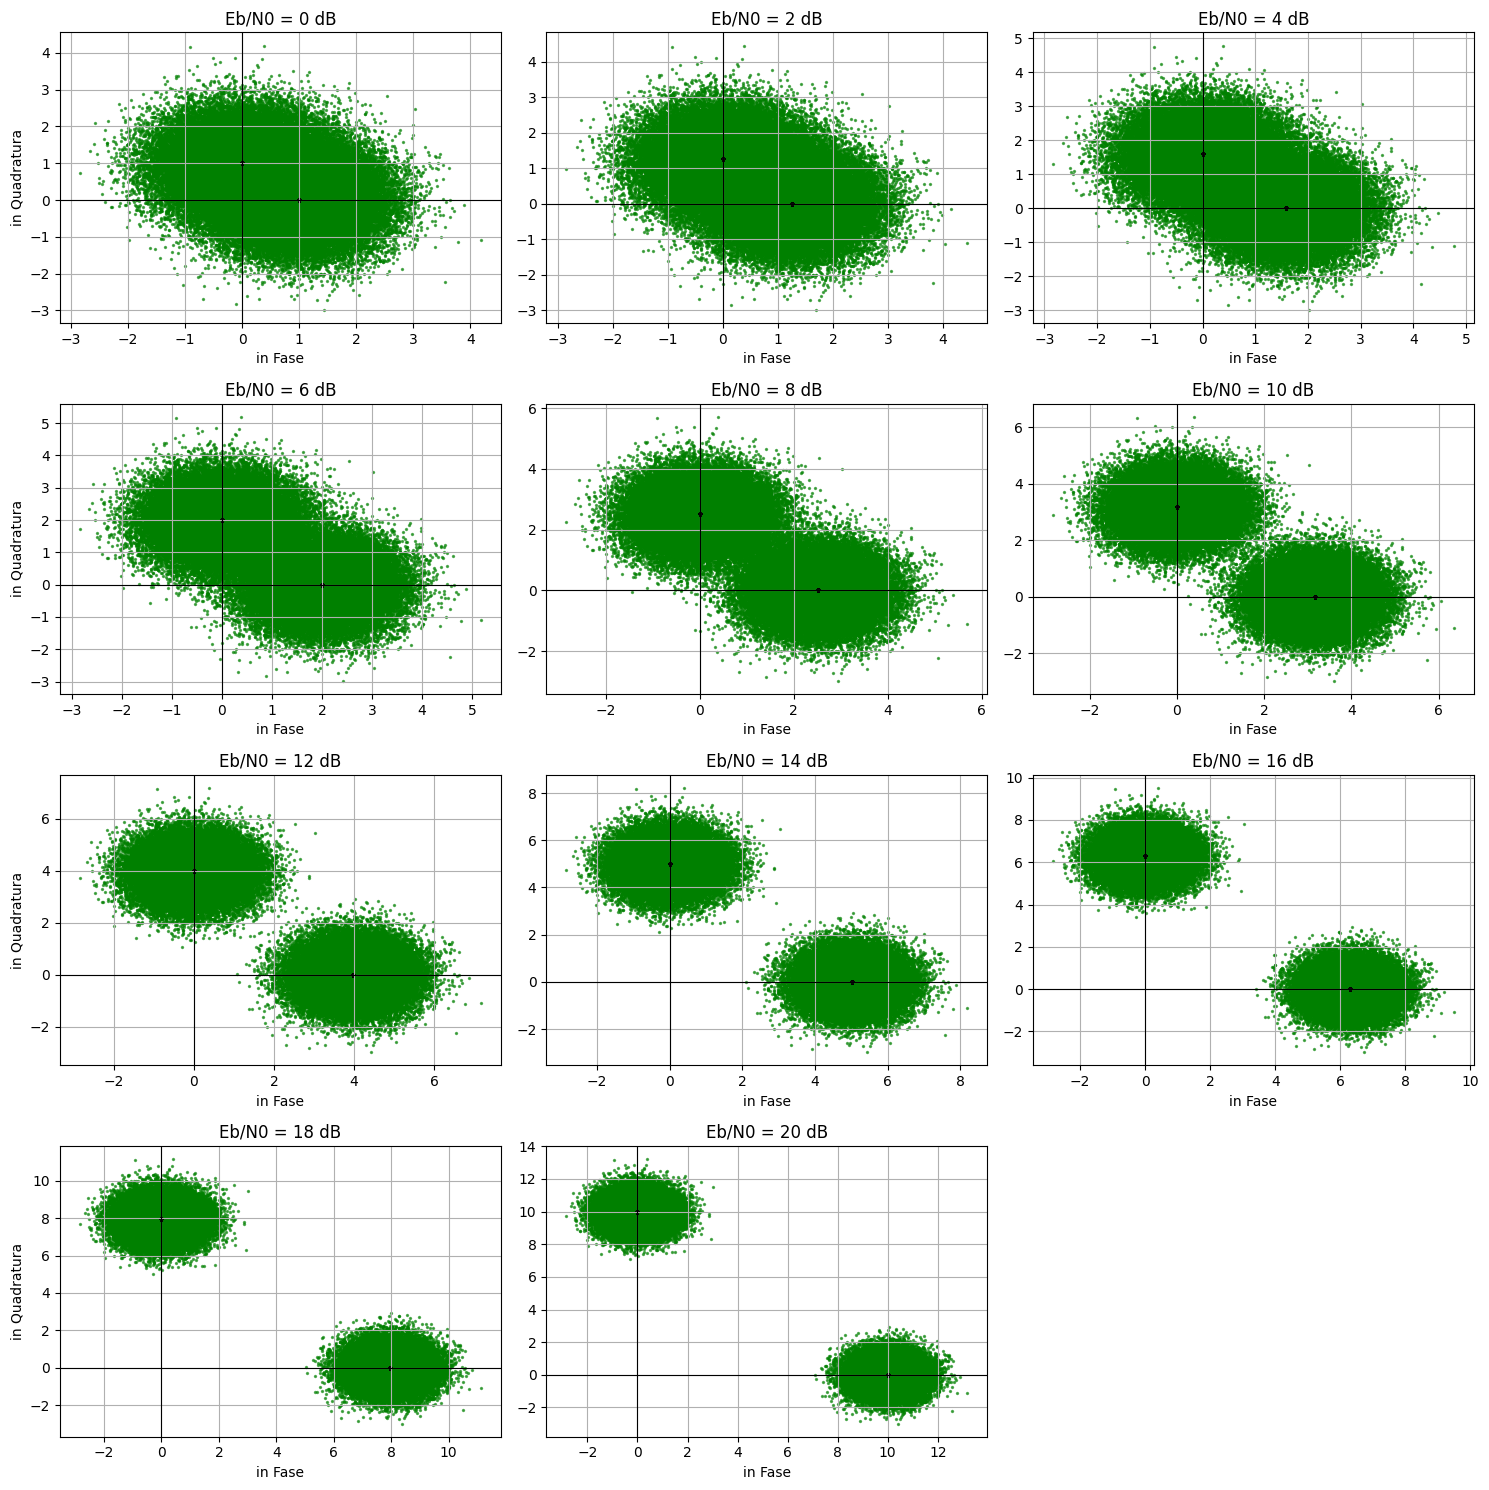

In [ ]:

### Configurazione del subplot
num_subplots = len(Eb_N0_dB) # 11 subpolt
cols = 3  # Numero di colonne nei subplot
rows = int(np.ceil(num_subplots / cols))  # Numero di righe necessario

# Creazione dei subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Per accedere agli assi in un array 1D


### Plot
#per ciascuno degli 11 Eb_N0, genera 1 segnale da 100mila bit
for p in range(len(Eb_N0)):

    sig = A[p]*np.sqrt(T) * xi_seq  # Segnale trasmesso = 100mila elementi (la dipendenza da Eb_N0 stava nella A "A[p]")
    sig_rx = sig + noise              # Segnale ricevuto = 100mila elementi: ciascun bit è stato affetto da un AWGN

    # Scatter plot nel subplot corrispondente
    ax = axes[p]
    ax.scatter(sig_rx.real, sig_rx.imag, s=2, color='green', label='Ricevuto', alpha=0.6) # s=1 sets the marker size to 1 for all points. Adjust as needed.
    ax.scatter(sig.real, sig.imag, s=3, color='black', marker='*', label='Trasmettitore')

    ax.axhline(0, color='k', linewidth=0.8)
    ax.axvline(0, color='k', linewidth=0.8)
    ax.set_title(f'Eb/N0 = {Eb_N0_dB[p]} dB')
    ax.set_xlabel('in Fase')
    ax.grid(True)
    if p % cols == 0:  # Solo la prima colonna mostra l'etichetta dell'asse y
        ax.set_ylabel('in Quadratura')

# Rimuovere assi vuoti se il numero di subplot è maggiore dei dati
for i in range(len(Eb_N0), len(axes)):
    fig.delaxes(axes[i])

# Layout e visualizzazione
plt.tight_layout()

# Aumentando l'energia, l'errore diminuisce

Aumentando l'energia, l'errore diminuisce

# 2. Simulazione Monte-Carlo


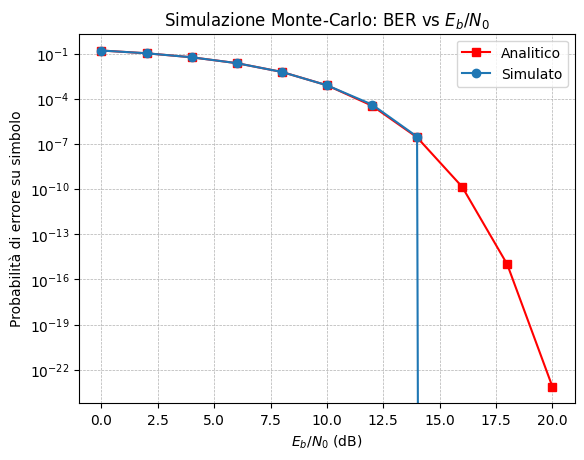

In [ ]:

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
num_prove = int(1e2)            # Numero di prove = 100


# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    for p in range(len(Eb_N0)):

        # Trasmettitore
        b_seq = (np.random.rand(int(K)) > soglia)  # Genera sequenza binaria da 100mila bit
        xi_seq = np.where(b_seq == 0, 1, 1j)  # If b_seq is 0, xi_seq is 1, else xi_seq is 1j
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part
        sig_rx = sig + noise                               # Segnale ricevuto

        # Ricevitore
        #b_seq_hat = sig_rx.real == 0              # Decisione del ricevitore: quando è 1j allora significa che è stato tramesso il bit 1 => troppo easy, infatti ho 0 di errore
        b_seq_hat = (sig_rx.imag > sig_rx.real)

        # Calcolo della probabilità d'errore sul bit (BER)
        P_e[p] += np.sum(b_seq != b_seq_hat) / K # Memorizzo il BER per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 BER ottenute dalle simulazioni ad 1dB



# Calcolo BER medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la BER media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = 0.5 * erfc(np.sqrt(Eb / (2*N0)))  #formula scpiegata nella L20



# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

# 3. Confronto tra modulazione antipodale e ortogonale


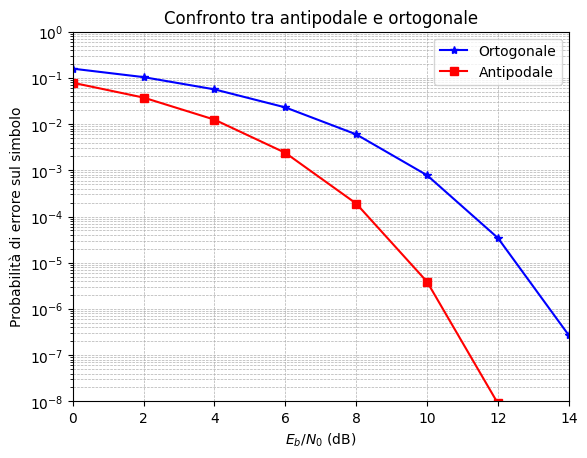

In [ ]:

### Calcolo delle probabilità di errore
P_e_ortogonale = 0.5 * erfc(np.sqrt(Eb / (2 * N0)))  # BER per confronto ortogonale
P_e_antipodale = 0.5 * erfc(np.sqrt(Eb / N0))        # BER per confronto antipodale

### Grafico
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_ortogonale, '-*b', label='Ortogonale')  # Probabilità ortogonale
plt.semilogy(Eb_N0_dB, P_e_antipodale, '-sr', label='Antipodale')  # Probabilità antipodale: Cambia solo il rad2: È quello responsabile dei 3db di scarto
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axis([0, 14, 1e-8, 1])  # Limiti degli assi
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore sul simbolo')
plt.legend()
plt.title('Confronto tra antipodale e ortogonale')
plt.show()

# A parità di energia l’ortogonale perde rispetto l’antipodale: spendo in più circa 3db

A parità di energia l’ortogonale perde rispetto l’antipodale: spendo in più circa 3db

# 4. Decisore con Intelligenza Artificiale: DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [ ]:
### preparazione dei dati per l'addestramento della rete

### Costellazione
b_seq = np.random.rand(int(K)) > soglia  # genera 100mila numeri casuali uniformemente distribuiti tra 0 e 1
xi_seq = np.where(b_seq == 0, 1, 1j)    # If b_seq is 0, xi_seq is 1, else xi_seq is 1j                                   # serve la normalizzazione: np.sqrt(1/2) ??????
noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part

print(b_seq.shape)
print(b_seq)
print(xi_seq.shape)
print(xi_seq)

xi_mod_phase = np.column_stack((np.abs(xi_seq), np.angle(xi_seq)))
print(np.abs(xi_mod_phase[0]), np.angle(xi_mod_phase[0]))
print(xi_mod_phase.shape)
print(xi_mod_phase)


(100000,)
[False  True False ... False False False]
(100000,)
[1.+0.j 0.+1.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
[1. 0.] [0. 0.]
(100000, 2)
[[1.         0.        ]
 [1.         1.57079633]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]


In [ ]:

### Addestramento
for p in range(len(Eb_N0)):

  sig = A[p] * np.sqrt(T) * xi_seq  # Segnale trasmesso = 100mila elementi (la dipendenza da Eb_N0 sta nella A)
  sig_rx = sig + noise              # Segnale ricevuto = 100mila elementi: ciascun bit è stato affetto da un AWGN


  ### Addestramento della rete

  # dati di input
  X_mod_phase = np.column_stack((np.abs(sig_rx), np.angle(sig_rx))) #gli diamo in input non 1 numero complesso, ma 2 numeri reali: il modulo e la fase

  # dati che vorrei che il modello imparasse a dare in output
  Y = b_seq.reshape(100000, -1)

  # training della rete
  model.fit(X_mod_phase,Y)


visualizziamo quale è il criterio di decisione che ha appreso il modello

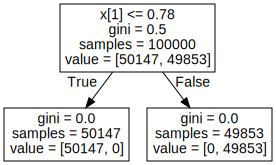

In [ ]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG

graph = Source( tree.export_graphviz(model, out_file=None))
SVG(graph.pipe(format='svg'))

#angolo di 45° corrisponde a un valore di fase di pi/4 cioè 0.7853

In [ ]:
### Test della rete come Decisore su 3 singoli valori a scelta da predire

#array di array formati da una coppia di valori: modulo(distanza) e fase(angolo)
valore_da_predire = [[1,1.57079633],[1,0],[0.3,0]]  #punti 1+1j,1+0j,un punto reale puro

# Crea un array NumPy contenente il valore da predire
input_value = np.array([valore_da_predire])

# Ridimensiona l'array per adattarlo al modello (come fatto durante l'addestramento)
input_value = input_value.reshape(3, -1)  # 3 perchè sono 3 valori da predire

# Esegui la predizione
prediction = model.predict(input_value)

# Stampa la predizione
print(prediction)



#BFSK è mappato così: se bit è 0 => reale, se 1 => immaginario

[ True False False]


utilizziamo la rete come Decisore nella Simulazione con metodo Monte-Carlo

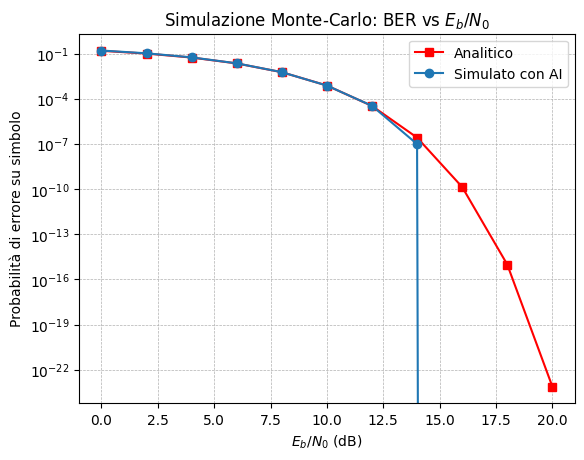

In [ ]:

# Parametri
P_e = np.zeros(len(Eb_N0))  # Inizializzazione della probabilità di errore a 0 = 11 elementi
num_prove = int(1e2)            # Numero di prove = 100

# Simulazione Monte-Carlo
# testa 100 volte la rice-trasmissione per ognuno degli 11 Eb_N0
for num in range(int(num_prove)):
    for p in range(len(Eb_N0)):

        # Trasmettitore
        b_seq = (np.random.rand(int(K))> soglia)  # Genera sequenza binaria da 100mila bit: (<0.5)-->False    (>0.5)-->True
        xi_seq = np.where(b_seq == 0, 1, 1j)    # If b_seq is 0, xi_seq is 1, else xi_seq is 1j                                   # serve la normalizzazione: np.sqrt(1/2) ??????
        sig = A[p] * np.sqrt(T) * xi_seq                # Segnale trasmesso: 1 segnale lungo 100mila

        # AWGN (Additive White Gaussian Noise)
        noise = np.sqrt(N0 / 2) * (np.random.randn(int(K))+1j*np.random.randn(int(K)))  # Rumore gaussiano real + imaginary part
        sig_rx = sig + noise                               # Segnale ricevuto
        sig_rx_mod_phase = np.column_stack((np.abs(sig_rx), np.angle(sig_rx)))

        # Ricevitore
        b_seq_hat = (model.predict(sig_rx_mod_phase))                 # Decisione del ricevitore: dato che l'output è -1 se <0 e 1 se >0, allora deve restituire True quando è -1 e False quando è 1

        # Calcolo della probabilità d'errore sul bit (BER)
        P_e[p] += np.sum(b_seq != b_seq_hat) / K # Memorizzo il BER per ogni Eb_N0
        #es) alla 100esima prova, P_e[0] conterrà la somma di 100 BER ottenute dalle simulazioni ad 1dB



# Calcolo BER medio su tutte le 100 prove
P_e = P_e / num_prove # Divido ciascun elemento di P_e[] per 100
#così avrò 11 elementi che rappresentano la BER media su 100 prove per quella specifica Eb_N0
#es) in P_e[10] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=100 cioè 20dB
#es) in P_e[5] avrò la BER media ottenuta durante le 100 prove di un rice-trasmettitore con un contrasto di energia di Eb_N0=10 cioè 10dB


# Calcolo della probabilità teorica
P_e_theoretical = 0.5 * erfc(np.sqrt(Eb / (2*N0)))



# Plot dei risultati
plt.figure()
plt.semilogy(Eb_N0_dB, P_e_theoretical, '-sr', label='Analitico')  # Risultati teorici
plt.semilogy(Eb_N0_dB, P_e, '-o', label='Simulato con AI')  # Risultati simulati
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilità di errore su simbolo') # in questo caso simbolo=bit
plt.legend()
plt.title('Simulazione Monte-Carlo: BER vs $E_b/N_0$')
plt.show()

# La simulazione si interrompe perché non riesce più a trovare errori: numero di prove insufficiente

link utili:


*  Tutorial DecisionTreeClassifier: https://www.youtube.com/watch?v=7eh4d6sabA0&ab_channel=ProgrammingwithMosh
*   Visualizzazione DecisionTreeClassifier: https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
*  Addestramento DecisionTreeClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit



